# Investigation One Univariate State Assignment

The dataset in this application is from a temperature sensor on an industrial cooling water flow. 

The data is read on a two second interval, and indexed $0,.., n$ as required by __trcrpm__.

The $3000$ samples show mostly normal/expected readings from the sensor. Between $1500$ and $2000$ the readings fluctuate rapidly - this fluctuation is due to aging/corroding contacts in the signal path.

The investigation is to determine whether __trcrpm__ is a valuable tool for identifying signal anomalies without an advance description of the signal characteristics, or some model of its dynamics.

The majority of this file is taken from the __trcrpm__ tutorials.  It is included to demonstrate the basic functionality of the code base, as well as to highlight intuitively, the __trcrpm__ algorithm.  

In [2]:
# the required python libraries imported
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from trcrpm import TRCRP_Mixture

In [3]:
# indicates to jupyer how the plots are to be displayed and sized
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 5]

In [4]:
# Read in the data from a CSV
data_clean = pd.read_csv("../data/data.csv", index_col=0)
data = data_clean

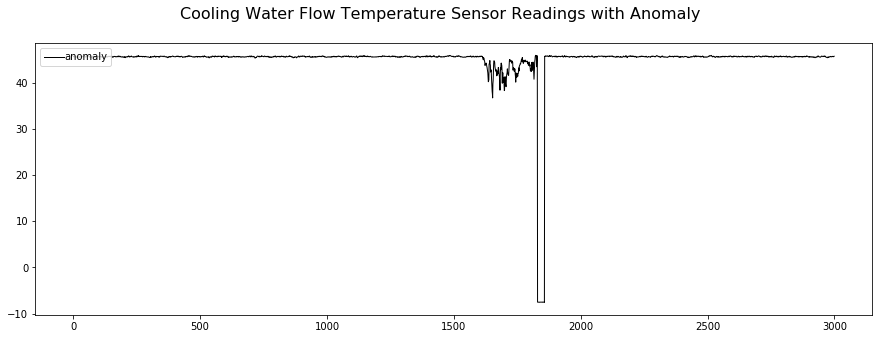

In [5]:
# Plot the data
fig, axes = plt.subplots(nrows=len(data.columns))
fig.suptitle('Cooling Water Flow Temperature Sensor Readings with Anomaly', fontsize=16)
index = list(data.columns).index(data.columns[0])
x_observed = data.index
y_observed = data.loc[:,data.columns[0]]
axes.plot(x_observed, y_observed, label=data.columns[0], color='k', linewidth=1)
axes.legend(loc='upper left', handletextpad=0)

In [6]:
# Provide entropy ~ number of time series
rng = np.random.RandomState(1)
# Create TRCRP_Mixture model object, with 8 MCMC chains, and a time dependency over the previous 200 samples
model = TRCRP_Mixture(chains=8, lag=10, variables=data.columns, rng=rng)
# Incorporate the data set into the model
model.incorporate(data)
# Run MCMC inference the latent state for #steps full Gibbs sweeps through all kernels
model.resample_all(steps=10)
# Run empirical Bayes on variable hyperparameters for full Gibbs sweeps through all kernels
model.resample_hyperparameters(steps=10)
# Set up an index/grid, and number of samples desire per index/grid point to run a simulation
probes = model.dataset.index
numsamples = 20
# Generate predictions from the posterior distribution.
samples = model.simulate(probes, model.variables, numsamples)

Completed: 10 iterations in 5.329044 seconds.
Completed: 10 iterations in 5.425392 seconds.
Completed: 10 iterations in 5.390785 seconds.
Completed: 10 iterations in 6.013720 seconds.
Completed: 10 iterations in 8.207722 seconds.
Completed: 10 iterations in 9.470590 seconds.
Completed: 10 iterations in 12.199408 seconds.
Completed: 10 iterations in 12.990410 seconds.
Completed: 10 iterations in 11.203105 seconds.
Completed: 10 iterations in 11.585291 seconds.
Completed: 10 iterations in 11.712684 seconds.
Completed: 10 iterations in 12.146112 seconds.
Completed: 10 iterations in 12.782935 seconds.
Completed: 10 iterations in 12.840479 seconds.
Completed: 10 iterations in 13.452202 seconds.
Completed: 10 iterations in 13.893267 seconds.


In [7]:
# Helper function to visualize state sequence changes in the model
def plot_latent_state_sequence(timesteps, values, states, ax):
    # sanity check
    assert len(timesteps) == len(states)
    # get unique state labels
    unique = sorted(set(states))
    # plot states
    colors = matplotlib.cm.Set1(np.linspace(0, 1, len(unique)))
    y_low, y_high = ax.get_ylim()
    y_mid = np.mean([y_low, y_high])
    y_height = 0.05 * (y_high - y_low)
    for state, color in zip(unique, colors):
        xs = timesteps[states==state]
        for x in xs:
            ax.fill_between([x-1, x], [y_mid-y_height]*2, [y_mid+y_height]*2,
                alpha=0.3, color=color)

In [8]:
# Helper function to plot model predictions from the posterior
def plot_predictions(simulations, variable, ax, states_from_chain=None):
    index = model.variables.index(variable)
    # Plot the observed data.
    x_observed = model.dataset.index
    y_observed = model.dataset.loc[:,variable]
    ax.plot(x_observed, y_observed, label=variable, color='k', linewidth=1)
    # Plot 25--75 percentile bands around the simulated data. 
    samples = simulations[:,:,index]
    ax.fill_between(
        probes,
        np.percentile(samples, 25, axis=0),
        np.percentile(samples, 75, axis=0),
        color='gray',
        alpha=0.5)
    #  Optionally plot latent temporal state at each timepoint,
    #  according to a given chain in the model.
    if states_from_chain is not None:
        assert 0 <= states_from_chain < model.chains
        # Get a list of states attributed to each sample
        states = model.get_temporal_regimes(variable)[states_from_chain]
        plot_latent_state_sequence(x_observed, y_observed, states, ax)
    # Add the legend.
    ax.legend(loc='upper left', handletextpad=0)

(0, 2999)

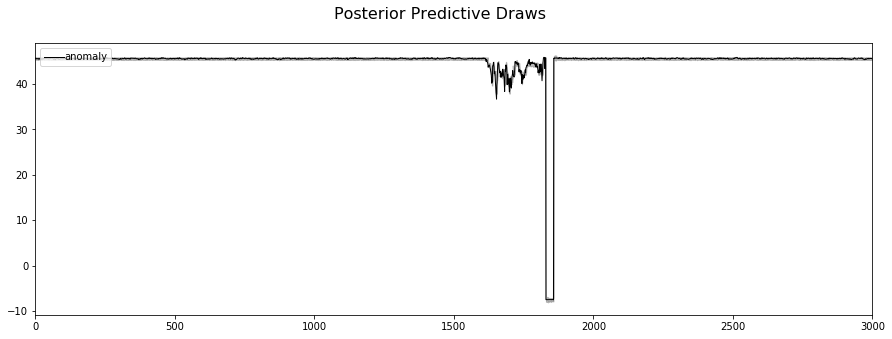

In [9]:
# Plot posterior predictive draws
fig, axes = plt.subplots(nrows=len(data.columns))
fig.suptitle('Posterior Predictive Draws', fontsize=16)
plot_predictions(samples, data.columns[0], axes)
axes.set_xlim([min(probes), max(probes)])

(0, 2999)

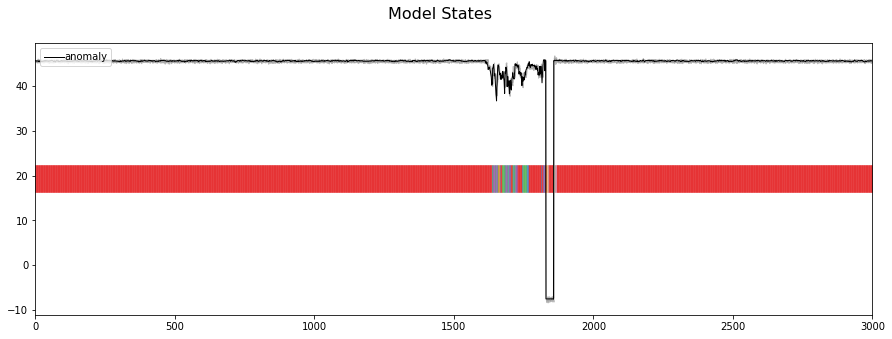

In [10]:
# Plot the model States as they change
chain = 0
samples_chain = samples[numsamples*chain:numsamples*(chain+1)]
fig, axes = plt.subplots(nrows=1)
fig.suptitle('Model States', fontsize=16)
plot_predictions(samples_chain,data.columns[0], axes, states_from_chain=chain)
axes.set_xlim([min(probes), max(probes)])